In [3]:
import sys
sys.path.append("C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs")
import cohpfuncs as cfunc
import jdftxfuncs as jfunc
data_dir = "E://perl//pscratch//beri9208//pot_scan//PtPyrOpt150//"
#data_dir = "D://scratch_backup//perl//pot_scan//AuPyrOpt//"
data_label = data_dir.split("//")[-2]
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from numba import jit
savedir = "C://Users//User//Desktop//pcoop_plots//bandwise//"
data_prefix = "output."

def app_dir(surf_idx, mu_idx):
    """
    :param surf_idx: 0 --> 2n-cis, 1 --> 2n-trans
    :param mu_idx: 0 --> No_bias, -1 --> dneg/1, 1 --> 2pos/1
    :return:
    """
    out_str = surf_labels[surf_idx] + "//"
    if mu_idx == 0:
        out_str += "No_bias//"
    else:
        if mu_idx > 0:
            out_str += "dpos//"
        else:
            out_str += "dneg//"
        out_str += str(int(abs(mu_idx))) + "//"
    return data_dir + out_str

#surf_labels = ["2n-cis", "2n-trans", "3n", "4n"]
surf_labels = ["2n-cis", "2n-cis"]
bias_labels = ["-0.3V", "0.0V", "0.3V", "0.6", "0.9V", "1.2V", "1.5V", "1.8V", "-2.4V", "-2.1V", "-1.8V", "-1.5V", "-1.2V", "-0.9V", "-0.6V"]
bidrange = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
bshift = int(np.floor(len(bidrange)/2.))
nbids = len(bidrange)
ncalcs = nbids*2

def gen_dirname(surf_idx, bias_idx):
    slabel = surf_labels[surf_idx]
    out_str = save_dir + slabel + str(bias_idx)
    out_str += '//'
    return out_str

def gen_savedirname(surf_idx, savedir):
    slabel = surf_labels[surf_idx]
    out_str = savedir + slabel
    out_str += '//'
    return out_str

def setupdir(dirname):
    try:
        os.mkdir(dirname)
    except:
        None
setupdir(savedir)


def gen_savename(surf_idx, bias_idx, j):
    out_str = str(j) + "_" + str(bias_idx) +  surf_labels[surf_idx]
    return out_str

def gen_title(surf_idx, bias_idx, j):
    out_str = str(j) + " " + bias_labels[bias_idx - bshift] + " " +  surf_labels[surf_idx]
    return out_str

@jit(nopython=True)
def lb_idx(Emin, dE, sample):
    a = sample-Emin
    b = a/dE
    c = int(np.floor(b))
    return c, abs(b-c)

def get_ebounds(surf_idcs, bias_idcs):
    minE = 0
    maxE = 0
    for sidx in surf_idcs:
        for bidx in bias_idcs:
            nStates = jfunc.get_n_states_cheap(app_dir(sidx, bidx) + "out")
            E = jfunc.parse_eigfile(app_dir(sidx, bidx) + data_prefix + "eigenvals", nStates)
            # output = cfunc.parse_data(app_dir(sidx, bidx) + data_prefix + "bandProjections", app_dir(sidx, bidx) + data_prefix + "Gvectors", app_dir(sidx, bidx) + data_prefix + "eigenvals")
            minE = min(minE, np.min(E))
            maxE = max(maxE, np.min(E))
    return minE, maxE

def get_erange(surf_idcs, bias_idcs, dE):
    minE, maxE = get_ebounds(surf_idcs, bias_idcs)
    minE += -20*dE
    maxE += 20*dE
    return np.arange(minE, maxE, dE)

# @jit(nopython=True)
# def get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, outij, dE, sw):
#     a = ejk - min(Erange)
#     b = a / dE
#     idx = int(np.floor(b))
#     for i in range(sw*5 + 1):
#         act = idx + i - sw
#         outij[act] += height*np.exp(-((Erange[act] - ejk)**2)/(sw*dE))
#
# @jit(nopython=True)
# def fiterable(orbi, orbj, nk, nj, E, proj, out, wk, Erange, dE, sw, i, j):
#     for u1 in orbi:
#             if u1 > 0:
#                 for v1 in orbj:
#                     if v1 > 0:
#                         for ik in range(nk):
#                             for ij in range(nj):
#                                 ejk = E[ik][ij]
#                                 t1 = proj[ik][ij][u1]
#                                 t2 = proj[ik][ij][v1]
#                                 t1_conj = t1.real - t1.imag * 1j
#                                 height = np.real(t1_conj * t2 * wk[ik])
#                                 get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, out[i,j], dE, sw)

# @jit(nopython=True)
# def get_overlap_matrix_plottable_smear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE, sw):
#     # Fix me eventually
#     # print('starting2')
#     for ii in list(range(len(orbs_sample))):
#         if ii == 37:
#             for jj in range(len(orbs_sample)):
#                 if jj == 40:
#                     orbi = orbs_sample[ii]
#                     orbj = orbs_sample[jj]
#                     fiterable(orbi, orbj, nk, nj, E, proj, out, wk, Erange, dE, sw, ii, jj)
#         else:
#             for jj in range(len(orbs_sample)):
#                 orbi = orbs_sample[ii]
#                 orbj = orbs_sample[jj]
#                 fiterable(orbi, orbj, nk, nj, E, proj, out, wk, Erange, dE, sw, ii, jj)
#     return out

@jit(nopython=True)
def get_band_vector_nosmear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    spill = abs(b-idx)
    outij[idx] += height*(1 - spill)
    outij[idx+1] += height*spill

@jit(nopython=True)
def get_band_vector_plottable_nosmear(E, wk, nk, nj, out, Erange, dE):
    for ij in range(nj):
        for ik in range(nk):
            ejk = E[ik][ij]
            height = wk[ik]
            get_band_vector_nosmear_helper(ejk, height, Erange, out[ij], dE)
    return out


@jit(nopython=True)
def get_plot_stuff(sidx, bidx, j, ndatum):
    dlook = ndatum[sidx][bidx]
    y = np.real(dlook[j])
    return y

def system_bandwise_plottable(surf_idx, bias_idx, Erange, dE):
    print("A")
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + data_prefix + "bandProjections",
        app_dir(surf_idx, bias_idx) + data_prefix + "Gvectors",
        app_dir(surf_idx, bias_idx) + data_prefix + "eigenvals")
    print("B")
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    print("C")
    nk, nj = np.shape(E)
    print(nj)
    out = np.zeros([nj, len(Erange)])
    band_vec = get_band_vector_plottable_nosmear(E, wk, nk, nj, out, Erange, dE)
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return band_vec, mu

In [4]:
surfs = len(surf_labels)
dE = 0.01
Erange = get_erange([0, 0], bidrange, dE)
datum = []
for i in range(surfs):
    print(i)
    datum.append([])
    for j in range(len(bias_labels)):
        print(j)
        start = time.time()
        datum[-1].append(system_bandwise_plottable(i, j - bshift, Erange, dE))
        end = time.time()
        elapsed = end - start
        print(str(i*len(bias_labels) + j + 1) + "/" + str(2*len(bias_labels)) + ": " + f'{elapsed:.{4}g}' )

0
0
A
B
C
150


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'wk' of function 'get_band_vector_plottable_nosmear'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_4708\2868134228.py", line 145:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


1/30: 2.361
1
A
B
C
150
2/30: 1.359
2
A
B
C
150
3/30: 1.362
3
A
B
C
150
4/30: 1.403
4
A
B
C
150
5/30: 1.288
5
A
B
C
150
6/30: 1.293
6
A
B
C
150
7/30: 1.233
7
A
B
C
150
8/30: 1.318
8
A
B
C
150
9/30: 1.25
9
A
B
C
150
10/30: 1.268
10
A
B
C
150
11/30: 1.284
11
A
B
C
150
12/30: 1.232
12
A
B
C
150
13/30: 1.311
13
A
B
C
150
14/30: 1.249
14
A
B
C
150
15/30: 1.211
1
0
A
B
C
150
16/30: 1.248
1
A
B
C
150
17/30: 1.279
2
A
B
C
150
18/30: 1.258
3
A
B
C
150
19/30: 1.225
4
A
B
C
150
20/30: 1.201
5
A
B
C
150
21/30: 1.254
6
A
B
C
150
22/30: 1.331
7
A
B
C
150
23/30: 1.223
8
A
B
C
150
24/30: 1.235
9
A
B
C
150
25/30: 1.223
10
A
B
C
150
26/30: 1.265
11
A
B
C
150
27/30: 1.235
12
A
B
C
150
28/30: 1.316
13
A
B
C
150
29/30: 1.339
14
A
B
C
150
30/30: 1.318


In [5]:
mus = []
for bidx in range(len(bias_labels)):
    mus.append(datum[0][bidx][1])
nj = len(datum[0][0][0])
ndatum = np.zeros([np.shape(datum)[0], len(bidrange), nj, len(Erange)])
for sidx in range(surfs):
    for bidx in range(len(bidrange)):
        for j in range(nj):
            ndatum[sidx, bidx, j] += np.real(datum[sidx][bidx][0][j])

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [6]:
y_bounds = np.zeros([len(surf_labels), nj, 2])
for sidx in range(surfs):
    for j in range(nj):
        miny = 0
        maxy = 0
        for bidx in range(len(bidrange)):
            miny = min(miny, np.nanmin(ndatum[sidx][bidx][j]))
            maxy = max(maxy, np.nanmax(ndatum[sidx][bidx][j]))
        y_bounds[sidx, j, 0] += miny
        y_bounds[sidx, j, 1] += maxy

def saveplot(sidx, bidx, j, savedir):
    y = get_plot_stuff(sidx, bidx, j, ndatum)
    plt.figure(figsize=(10,5))
    plt.plot(Erange, y)
    plt.axvline(x=mus[bidx], color='red')
    plt.title(gen_title(sidx, bidx, j))
    yb = y_bounds[sidx, j]
    plt.ylim(yb[0], yb[1])
    plt.savefig(gen_savedirname(sidx, savedir) + gen_savename(sidx, bidx, j) + '.png')
    plt.clf()

Text(0.5, 1.0, '0 -2.4V 2n-cis')

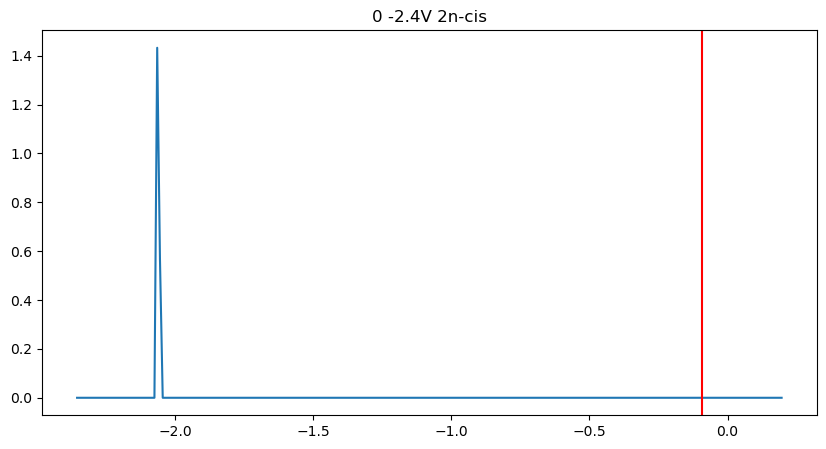

In [7]:
y = get_plot_stuff(0, 0, 0, ndatum)
plt.figure(figsize=(10,5))
plt.plot(Erange, y)
plt.axvline(x=mus[0], color='red')
plt.title(gen_title(0, 0, 0))

In [ ]:
sidx = 0
setupdir(gen_savedirname(sidx, savedir))
for bidx in range(len(bidrange)):
    start = time.time()
    for j in range(nj):
        saveplot(sidx, bidx, j, savedir)
    end = time.time()
    elapsed = end - start
    print(str(sidx*len(bidrange) + bidx + 1) + "/" + str(len(bidrange)*2) + ": " + f'{elapsed:.{4}g}' + 'seconds')

In [ ]:
sidx = 1
setupdir(gen_savedirname(sidx, savedir))
for bidx in range(len(bidrange)):
    start = time.time()
    for j in range(nj):
        saveplot(sidx, bidx, j, savedir)
    end = time.time()
    elapsed = end - start
    print(str(sidx*len(bidrange) + bidx + 1) + "/" + str(len(bidrange)*2) + ": " + f'{elapsed:.{4}g}' + 'seconds')

In [ ]:
sidx = 2
setupdir(gen_savedirname(sidx, savedir))
for bidx in range(len(bidrange)):
    start = time.time()
    for j in range(nj):
        saveplot(sidx, bidx, j, savedir)
    end = time.time()
    elapsed = end - start
    print(str(sidx*len(bidrange) + bidx + 1) + "/" + str(len(bidrange)*2) + ": " + f'{elapsed:.{4}g}' + 'seconds')

In [ ]:
sidx = 1
setupdir(gen_savedirname(sidx, savedir))
for bidx in range(len(bidrange))[:int(len(bidrange)/2)]:
    start = time.time()
    for ai in range(natoms):
        for aj in list(range(natoms))[ai:]:
            ai_use = natoms - ai - 1
            aj_use = natoms - aj - 1
            saveplot(sidx, bidx, ai_use, aj_use, savedir)
    end = time.time()
    elapsed = end - start
    print(str(sidx*len(bidrange) + bidx + 1) + "/" + str(len(bidrange)*2) + ": " + f'{elapsed:.{4}g}' + 'seconds')

In [ ]:
sidx = 1
setupdir(gen_savedirname(sidx, savedir))
for bidx in range(len(bidrange))[int(len(bidrange)/2):]:
    start = time.time()
    for ai in range(natoms):
        for aj in list(range(natoms))[ai:]:
            ai_use = natoms - ai - 1
            aj_use = natoms - aj - 1
            saveplot(sidx, bidx, ai_use, aj_use, savedir)
    end = time.time()
    elapsed = end - start
    print(str(sidx*len(bidrange) + bidx + 1) + "/" + str(len(bidrange)*2) + ": " + f'{elapsed:.{4}g}' + 'seconds')